# A/A/B-тест мобильного приложения по продаже продуктов питания.

## Описание проекта

Стартап продаёт продукты питания. 

Нужно разобраться, как ведут себя пользователи мобильного приложения:

- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

- Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работать будем с одними и теми же данными.

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth
from statsmodels.stats.multitest import multipletests

### Считывание данных и изучение общей информации

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
logs.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


#### Вывод

Датафрейм содержит следующие столбцы:

- **EventName** — название события;


- **DeviceIDHash** — уникальный идентификатор пользователя;


- **EventTimestam** — время события;


- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

В общем сожержится  информация о 244126 событиях. 

### Преобработка данных

#### Замена названий столбцов

In [5]:
logs.columns = ['event_name', 'user_id', 'timestamp', 'group']

#### Изменение типов данных

In [6]:
# преобразование типа данных в столбце о времени

logs.timestamp = pd.to_datetime(logs.timestamp, unit='s')

In [7]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   timestamp   244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


#### Проверка пропусков, дубликатов и типов данных.

In [8]:
#пропуски:

logs.isna().sum()

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64

Пропусков в данных не обнаружено

In [9]:
#явные дубликаты:

logs.duplicated().sum()

413

Обнаружено 413 явных дубликатов

In [10]:
#посчитаем долю явных дубликатов, чтобы понять можно ли их удалить

print(f"Доля явных дубликатов составляет {logs.duplicated().sum()/logs['user_id'].count():.1%}")

Доля явных дубликатов составляет 0.2%


In [11]:
#удалим явные дубликаты так как их доля менее 1 %

logs = logs.drop_duplicates().reset_index(drop=True)

In [12]:
# проверим еще раз на явные дубликаты после удаления

logs.duplicated().sum()

0

In [13]:
# посмотрим общую ифнормацию после удаления

logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


#### Добавление столбца даты и времени, а также отдельного столбца дат

In [14]:
# Создадим столбец`datetime` с датой и временем:

logs['dt'] = pd.to_datetime(logs['timestamp'], unit='s')

In [15]:
# Добавим столбец с датой:

logs['date'] = pd.to_datetime(logs['dt'].dt.date)

In [16]:
logs.head()

,event_name,user_id,timestamp,group,dt,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25


#### Проверка на пересечение пользователей в группах

In [17]:
#создадим списки уникальных пользователей в каждой группе

g246 = logs.query('group == 246')['user_id'].unique()
g247 = logs.query('group == 247')['user_id'].unique()
g248 = logs.query('group == 248')['user_id'].unique()

In [18]:
#проверим пересечения в группах 246 и 247

intersection_1 = []
for i in g246:
  if i in g247:
    intersection_1.append(i)
print(len(intersection_1))

0


In [19]:
#проверим пересечения в группах 246 и 248

intersection_2 = []
for i in g246:
  if i in g248:
    intersection_2.append(i)
print(len(intersection_2))

0


In [20]:
#проверим пересечения в группах 247 и 248

intersection_3 = []
for i in g247:
  if i in g248:
    intersection_3.append(i)
print(len(intersection_3))

0


#### Вывод

На этапе предобработки данных:

- произведена замена названий столбцов
- изменен тип данных в столбце о времени
- пропусков в данных не обнаружено
- обнаружено число явных дубликатов 413, что составляет 0,2% от общих данных, поэтому они были удалены
- создали столбец с датой и временем
- создали отдельный столбец с датами
- пересечение данных в группах не выявлено


## Изучение и проверка данных

### Общее количество событий в логе

In [21]:
logs['event_name'].count()

243713

In [22]:
print(f'Всего в логе осталось {len(logs)} событий.')

Всего в логе осталось 243713 событий.


### Общее количество пользователей в логе

In [23]:
logs['user_id'].nunique()

7551

In [24]:
print(f'Всего пользователей в логе {len(logs.user_id.unique())}.')

Всего пользователей в логе 7551.


### Сколько в среднем событий приходится на пользователя

In [25]:
logs.groupby('user_id')['event_name'].agg('count').median() #медианное значение

20.0

In [26]:
print(f'В среднем на пользователя приходится {int(len(logs) / len(logs.user_id.unique()))} события.')

В среднем на пользователя приходится 32 события.


In [27]:
round(logs.groupby('user_id')[['event_name']].count().describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]),0)

,event_name
count,7551.0
mean,32.0
std,65.0
min,1.0
5%,3.0
25%,9.0
50%,20.0
75%,37.0
95%,89.0
99%,200.0


В среднем, на каждого пользователя приходится 32 события. 

Медианна составляет 20 событий.

У одного процента пользователей  количество событий более 200.

### Определение максимальной и минимальной даты данных которыми располагаем

In [28]:
#минимальная дата:

print(logs['dt'].min())

2019-07-25 04:43:36


In [29]:
#максимальная дата:

print(logs['dt'].max())

2019-08-07 21:15:17


### Построение столбчатой диаграммы, которая отобразит количество событий в зависимости от времени в разрезе групп

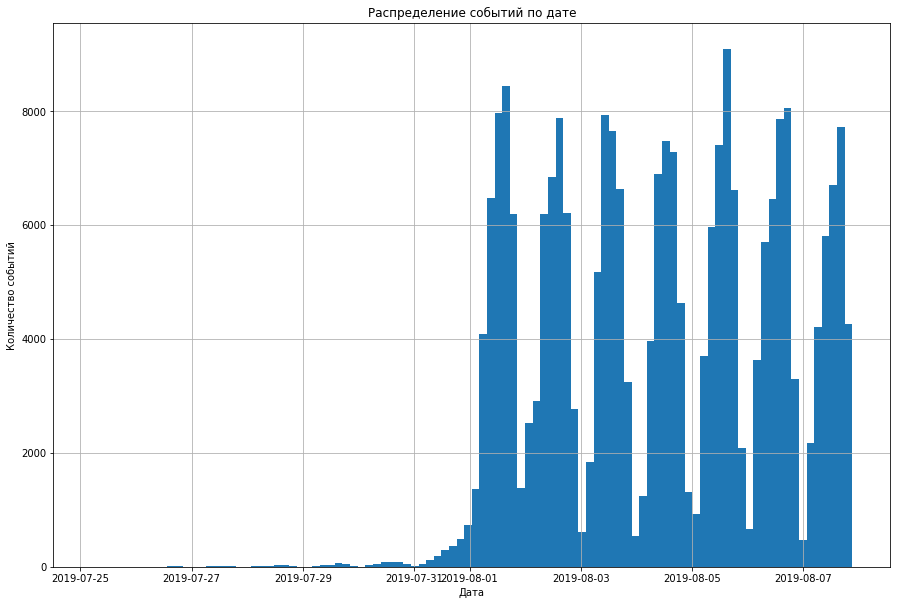

In [30]:
logs['dt'].hist(bins=100,  figsize=(15, 10))
plt.title('Распределение событий по дате')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.show()

**Даны данные за две недели: с 25.07.19 по 07.08.2019.
По гистограмме видно, что с 01.08.19 произошел резкий скачок в данных, поэтому данные до этой даты вероятно можно считать устаревшими.**

### Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Отбросим более старые данные

In [31]:
#отбросим период с неполными датами:

logs_act = logs.query('dt >= "2019-08-01"')

In [32]:
print(f'{(len(logs_act) / len(logs)):.2%} - доля событий после фильтрации')
print(f'Всего пользователей после фильтрации {len(logs_act.user_id.unique())}.')
print()
print(logs_act.groupby('group')['user_id'].nunique())

98.84% - доля событий после фильтрации
Всего пользователей после фильтрации 7534.

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


**После того как отбросили период с неполными данымми, начиная от 1 августа 2019 года, осталось 98,84% данных.**

### Проверка - много ли событий и пользователей  потеряли, отбросив старые данные

In [33]:
#посчитаем потерю событий:

len(logs) - len(logs_act)

2826

In [34]:
print(f"доля потерянных событий {(len(logs) - len(logs_act))/len(logs):.1%}")

доля потерянных событий 1.2%


In [35]:
#посчитаем потерю пользователей:

logs['user_id'].nunique()-logs_act['user_id'].nunique()

17

In [36]:
print(f"доля потерянных пользователей {(logs['user_id'].nunique()-logs_act['user_id'].nunique())/logs['user_id'].nunique():.1%}")

доля потерянных пользователей 0.2%


### Проверка - есть пользователи из всех трёх экспериментальных групп

In [37]:
#проверим, есть ли пользователи из всех трёх экспериментальных групп.

print(logs_act.groupby('group')['user_id'].nunique())

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### Вывод

До фильтрации:

- событий в логе: 243713

- уникальных пользователей: 7551

- В среднем, на каждого пользователя приходится 32 события.Медианна составляет 20 событий.У одного процента пользователей количество событий более 200.


Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07

Обросили неполные данные и посчитали потери:

-потеря событий всего 2826 из 243713 (1,2%)

-потеря пользователей 17 из 7551 (0,2%)

Таким образом, после фильтрации остается почти 99% лога и 7534 из 7551 пользователей. Среди них представители всех трех групп эксперимента и размеры групп примерно равны.

## Изучение воронки событий

### Просмотр -  какие события есть в логах, как часто они встречаются. Отсортирование событий по частоте

In [38]:
logs_act.groupby('event_name').agg(count = ('user_id', 'count')).sort_values(by = 'count', ascending=False)

,count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Событий пять:

**MainScreenAppear** - просмотр главной страницы

**OffersScreenAppear** - просмотр страницы предложений

**CartScreenAppear** - просмотр корзины

**PaymentScreenSuccessful** - переход на страницу успешной оплаты

**Tutorial** - просмотр обучающей информации для новых пользователей

### Подсчет, сколько пользователей совершали каждое из событий. Отсортирование событий по числу пользователей. Подсчет доли пользователей, которые хоть раз совершали событие

In [39]:
user_per_event = logs_act.groupby('event_name').agg(users=('user_id','nunique')).sort_values('users', ascending=False)
user_per_event['ratio'] = round(user_per_event['users']/logs_act['user_id'].nunique() * 100, 2)
user_per_event

,users,ratio
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Не все пользователи проходят через просмотр главной страницы 98.47%.

Самый большой скачок посещаемости - между главной страницей и страницей предложений - почти 40% пользователей туда не приходят.

Всего до успешной оплаты доходят 47% пользователей приложения.

### Предположение о порядке происхождения событий

Предположим, что пользователь:

1. сначала открывает главную страницу приложения(MainScreenAppear)

2. потом в каталоге выбирает товары(OffersScreenAppear)

3. кладёт их в корзину(CartScreenAppear)

4. оплачивает(PaymentScreenSuccessful)

руководство в эту цепочку не входит(Tutorial)

### По воронке событий поcчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [40]:
#создадим сводную таблицу с количеством уникальных пользователей совершавших каждое из событий

user_to_event = logs.query('event_name != "Tutorial"').pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)

In [41]:
#добавим столбец со смещенными значениями количества пользователей методом shift

#недостающее значение заполним первым значением столбца параметром fill_value

user_to_event['shift'] = user_to_event['user_id'].shift(1, fill_value = user_to_event['user_id'].loc[user_to_event.index[0]])

In [42]:
#посчитаем и добавим столбец с конверсией округленной до 1 десятка

user_to_event['conversion'] = round(user_to_event['user_id']/user_to_event['shift']*100, 1)

In [43]:
#в итоговой таблице оставим только количество уникальных пользователей и конверсией

user_to_event = user_to_event[['user_id', 'conversion']]
user_to_event

,user_id,conversion
event_name,,
MainScreenAppear,7439,100.0
OffersScreenAppear,4613,62.0
CartScreenAppear,3749,81.3
PaymentScreenSuccessful,3547,94.6


### На каком шаге теряется больше всего пользователей

Большинство пользователей теряется после просмотра главной страницы и переходом в каталог (около 40%).

### Какая доля пользователей доходит от первого события до оплаты

In [44]:
print(f"Доля пользователей прошедших от первого события до оплаты {user_to_event['user_id'].loc[user_to_event.index[-1]]/user_to_event['user_id'].loc[user_to_event.index[0]]:.1%}")

Доля пользователей прошедших от первого события до оплаты 47.7%


### Вывод

Как часто встречаются события в логе:

- **MainScreenAppear** - 117328 раз

- **OffersScreenAppear** - 46333 раз

- **CartScreenAppear** - 42303 раз

- **PaymentScreenSuccessful** - 33918 раз

- **Tutorial** - 1005 раз.


Сколько пользователей совершали каждое из событий и долю пользователей, которые хоть раз совершали событие:


- **MainScreenAppear** - 7419 пользователей (98.47%)

- **OffersScreenAppear** - 4593 пользователей (60.96%)

- **СartScreenAppear** - 3734 пользователей (49.56%)

- **PaymentScreenSuccessful** - 3539 пользователей (46.97%)

- **Tutoria** - 840 пользователей (11.15%)


**Предположительно события происходят в следующем порядке:**

1. Пользователь открывает главную страницу приложения (MainScreenAppear)

2. Переходит в каталог(OffersScreenAppear)

3. Выбранные товары кладет в корзину(CartScreenAppear)

4. Оплачивает(PaymentScreenSuccessful)


Откинули событие Tutorial, так как руководство в эту цепочку не входит

По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

- до второго шага доходит 4613 пользователей, доля от предыдущего шага 62.0%

- до третьего шага доходит 3749 пользователей, доля от предыдущего шага 81.3%

- до четвертого шага доходит 3547, доля от предыдущего шага 94.6%


Больше всего пользователей теряется на втором шаге: доля тех кто зашел на главную страницу и перешел в каталог - 62.0%


Доля пользователей прошедших от первого события до оплаты 47.7%

## Изучение результатов эксперимента

### Сколько пользователей в каждой экспериментальной группе

In [45]:
logs_act.pivot_table(index = 'group', values = 'user_id', aggfunc = 'nunique')

,user_id
group,
246,2484
247,2513
248,2537


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов нужно проверить находят ли статистические критерии разницу между выборками 246 и 247

**Критерии успешного A/A-теста:**

- Количество пользователей в различных группах различается не более, чем на 1%;

- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;

- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).

In [46]:
#Создадим отдельные датасеты с группами

group_246 = logs_act.query('group == 246')
group_247 = logs_act.query('group == 247')
group_248 = logs_act.query('group == 248')

In [47]:
#самое популярное событие в группе 246
group_246.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


In [48]:
#самое популярное событие в группе 247
group_247.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


In [49]:
# составим общую таблицу пользователей по группам и событиям

events_groups = logs_act.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique', margins=True).reset_index().sort_values('All', ascending=False).reset_index(drop=True)
events_groups = events_groups.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
events_groups

group,event_name,246,247,248,All
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,Tutorial,278,283,279,840
5,All,2484,2513,2537,7534


**Самым популярным событием является посещение главной страницы - MainScreenAppear**

**Гипотезы:**

**Нулевая гипотеза H0**:Между долями статистической значимой разницы нет, поведение групп не отличается

**Альтернативная гипотеза H1**:Между долями статистическая значимая разница есть, поведение групп отличается.

In [50]:
#критический уровень статистической значимости
alpha = 0.05
    
#количсество уникальных пользователей совершивших событие в каждой группе 
un_users_event = np.array([group_246[group_246['event_name'] == 'MainScreenAppear']['user_id'].nunique(), group_247[group_247['event_name'] == 'MainScreenAppear']['user_id'].nunique()])
        
#количество уникальных пользователей в группах
un_users_group = np.array([group_246['user_id'].nunique(), group_247['user_id'].nunique()])
    
# пропорция успехов в первой группе:
p1 = un_users_event[0]/un_users_group[0]
# пропорция успехов во второй группе:
p2 = un_users_event[1]/un_users_group[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
# разница пропорций в датасетах
difference = p1 - p2
    
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/un_users_event[0] + 1/un_users_event[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  
    
#Так как распределение статистики нормальное, вызовем метод cdf()
#Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
#Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
p_value = (1 - distr.cdf(abs(z_value))) * 2
          
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [51]:
#напишем функцию теста статистических различий между группами
def test(g1, g2, event_name):
    
    #критический уровень статистической значимости
    alpha = 0.05
    
    #количсетво уникальных пользователей совершивших событие в каждой группе 
    un_users_event = np.array([g1[g1['event_name'] == event_name]['user_id'].nunique(), g2[g2['event_name'] == event_name]['user_id'].nunique()])
        
    #количество уникальных пользователей в группах
    un_users_group = np.array([g1['user_id'].nunique(), g2['user_id'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = un_users_event[0]/un_users_group[0]
    # пропорция успехов во второй группе:
    p2 = un_users_event[1]/un_users_group[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/un_users_event[0] + 1/un_users_event[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #Так как распределение статистики нормальное, вызовем метод cdf()
    #Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
    #Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [52]:
#создадим список с уникальными событиями:
event_name_array = logs['event_name'].unique()
#создадим цикл, который будет подставлять в функцию уникальные значения собитый:
for event_name in event_name_array:
    test(group_246, group_247, event_name)

MainScreenAppear
p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2784401253423807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.39432110136773835
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.36593695068605325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.9791070433857165
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно.**

### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой

In [53]:
#Аналогично проверим 1 контрольную группу 246 с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(group_246, group_248, event_name)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.941774193649735
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы в поведении пользователей групп 246 и 248 нет**

In [54]:
#Проверим 2 контрольную группу 247 с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(group_246, group_248, event_name)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.941774193649735
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы в поведении пользователей групп 247 и 248 нет**

In [55]:
#объеденим группы методом pd.concat
group_246_247 = pd.concat([group_246, group_247])

In [56]:
#Проверим объедененную контрольную группу с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(group_246_247, group_248, event_name)

MainScreenAppear
p-значение:  0.2982116211407275
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7202057779473505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.34982490083868933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.5425331263544062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.9207162647272609
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет.**

**Можно сделать вывод о том, что изменение шрифтов в приложении не повлияло на наведение пользователей.**

### Подсчет сколько проверок статистических гипотез сделали

Всего сделали 20 проверок статистических гипотез. По-скольку были проведены множественные тесты необходимо применить поправку Шидака и перепроверить результаты тестов повторно.

Скорректируем значение уровня значимости методом Шидака по формуле: alpha_shidok_corr =  1 - (1-0.05)** (1/20)

In [57]:
alpha_shidok_corr = 1-(1-0.05)**(1/20)
alpha_shidok_corr

0.0025613787765302876

In [58]:
#напишем функцию теста статистических различий между группами с учетом поправки Шидака
def test_shidok_corr(g1, g2, event_name):
    
    #критический уровень статистической значимости
    alpha_shidok_corr = 0.003
    
    #количсетво уникальных пользователей совершивших событие в каждой группе 
    un_users_event = np.array([g1[g1['event_name'] == event_name]['user_id'].nunique(), g2[g2['event_name'] == event_name]['user_id'].nunique()])
        
    #количество уникальных пользователей в группах
    un_users_group = np.array([g1['user_id'].nunique(), g2['user_id'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = un_users_event[0]/un_users_group[0]
    # пропорция успехов во второй группе:
    p2 = un_users_event[1]/un_users_group[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/un_users_event[0] + 1/un_users_event[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #Так как распределение статистики нормальное, вызовем метод cdf()
    #Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
    #Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha_shidok_corr:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

**Повторно для всех тестов перпроверим результаты:**

In [59]:
for event_name in event_name_array:
    test_shidok_corr(group_246, group_247, event_name)

MainScreenAppear
p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2784401253423807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.39432110136773835
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.36593695068605325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.9791070433857165
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [60]:
for event_name in event_name_array:
    test_shidok_corr(group_246, group_248, event_name)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.941774193649735
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [61]:
for event_name in event_name_array:
    test_shidok_corr(group_246, group_248, event_name)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.941774193649735
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [62]:
for event_name in event_name_array:
    test_shidok_corr(group_246_247, group_248, event_name)

MainScreenAppear
p-значение:  0.2982116211407275
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7202057779473505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.34982490083868933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.5425331263544062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.9207162647272609
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод: с учетом поправки Шидака результаты тестов не изменились**

### Вывод

Количество уникальных пользователей в каждой группе:

- в **246 группе 2484 уникальных пользователей**

- в **247 группе 2513 уникальных пользователей**

- в **248 группе 2537 уникальных пользователей**

Были совершены следующие действия:

- Выбрали самое популярное событие - MainScreenAppear 

- Посчитали число пользователей, совершивших это событие в каждой из контрольных групп

- Посчитали долю пользователей, совершивших это событие

- Проверели, будет ли отличие между группами статистически достоверным. Проделали то же самое для всех других событий

- Создали функцию для теста статистических различий между группами для каждого события

**Аналогично поступили с группой с изменённым шрифтом:**

- сравнили результаты с каждой из контрольных групп в отдельности по каждому событию

- сравнили результаты с объединённой контрольной группой

**Итоги:**

1. сравнение групп 246 и 247:
    - Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно.
2. сравнение групп 246 и 248:
    - Значимой разницы в поведении пользователей групп 246 и 248 нет.
3. сравнение групп 247 и 248:
    - Значимой разницы в поведении пользователей групп 247 и 248 нет.
4. сравнение групп 246+247 и 248:
    - Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет.

## Вывод


Стартап продаёт продукты питания. 

Нужно разобраться, как ведут себя пользователи мобильного приложения:

- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

- Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работать будем с одними и теми же данными.

Каждая запись в логе — это действие пользователя, или событие. 

**EventName** — название события;

**DeviceIDHash** — уникальный идентификатор пользователя;

**EventTimestamp** — время события;

**ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

В общем сожержится  информация о 244126 событиях. 


На этапе предобработки данных:

- произведена замена названий столбцов
- изменен тип данных в столбце о времени
- пропусков в данных не обнаружено
- обнаружено число явных дубликатов 413, что составляет 0,2% от общих данных, поэтому они были удалены
- создали столбец с датой и временем
- создали отдельный столбец с датами
- пересечение данных в группах не выявлено

До фильтрации:

- событий в логе: 243713

- уникальных пользователей: 7551

- В среднем, на каждого пользователя приходится 32 события.Медианна составляет 20 событий.У одного процента пользователей количество событий более 200.


Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07

Обросили неполные данные и посчитали потери:

-потеря событий всего 2826 из 243713 (1,2%)

-потеря пользователей 17 из 7551 (0,2%)

Таким образом, после фильтрации остается почти 99% лога и 7534 из 7551 пользователей. Среди них представители всех трех групп эксперимента и размеры групп примерно равны.

Как часто встречаются события в логе:

- **MainScreenAppear** - 117328 раз

- **OffersScreenAppear** - 46333 раз

- **CartScreenAppear** - 42303 раз

- **PaymentScreenSuccessful** - 33918 раз

- **Tutorial** - 1005 раз.


Сколько пользователей совершали каждое из событий и долю пользователей, которые хоть раз совершали событие:


- **MainScreenAppear** - 7419 пользователей (98.47%)

- **OffersScreenAppear** - 4593 пользователей (60.96%)

- **СartScreenAppear** - 3734 пользователей (49.56%)

- **PaymentScreenSuccessful** - 3539 пользователей (46.97%)

- **Tutoria** - 840 пользователей (11.15%)


**Предположительно события происходят в следующем порядке:**

1. Пользователь открывает главную страницу приложения (MainScreenAppear)

2. Переходит в каталог(OffersScreenAppear)

3. Выбранные товары кладет в корзину(CartScreenAppear)

4. Оплачивает(PaymentScreenSuccessful)


Откинули событие Tutorial, так как руководство в эту цепочку не входит

По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

- до второго шага доходит 4613 пользователей, доля от предыдущего шага 62.0%

- до третьего шага доходит 3749 пользователей, доля от предыдущего шага 81.3%

- до четвертого шага доходит 3547, доля от предыдущего шага 94.6%


Больше всего пользователей теряется на втором шаге: доля тех кто зашел на главную страницу и перешел в каталог - 62.0%


Доля пользователей прошедших от первого события до оплаты 47.7%

**Критерии успешного A/A-теста:**

- Количество пользователей в различных группах различается не более, чем на 1%;

- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;

- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.


Критический уровень статистической значимости мы брали alpha = 0.05, это озачает что мы рискуем получить ошибку первого рода в одном из 20 случаев. 

Мы провели 20 экспериментов. Если бы взяли больший уровень значимости, например 0.1, вероятность увидеть ложноположительный результат была бы выше в 2 раза.

Количество уникальных пользователей в каждой группе:

- в **246 группе 2484 уникальных пользователей**

- в **247 группе 2513 уникальных пользователей**

- в **248 группе 2537 уникальных пользователей**

Были совершены следующие действия:

- Выбрали самое популярное событие - MainScreenAppear 

- Посчитали число пользователей, совершивших это событие в каждой из контрольных групп

- Посчитали долю пользователей, совершивших это событие

- Проверели, будет ли отличие между группами статистически достоверным. Проделали то же самое для всех других событий

- Создали функцию для теста статистических различий между группами для каждого события

**Аналогично поступили с группой с изменённым шрифтом:**

- сравнили результаты с каждой из контрольных групп в отдельности по каждому событию

- сравнили результаты с объединённой контрольной группой

**Итоги:**

1. сравнение групп 246 и 247:
    - Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно.
2. сравнение групп 246 и 248:
    - Значимой разницы в поведении пользователей групп 246 и 248 нет.
3. сравнение групп 247 и 248:
    - Значимой разницы в поведении пользователей групп 247 и 248 нет.
4. сравнение групп 246+247 и 248:
    - Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет.


**Вывод:**

**Множесто А/В-тестов, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов в приложении на поведение пользователей не повлияло.**